In [1]:
# %matplotlib widget
%matplotlib inline
# %matplotlib qt5

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

from qick import *
from qick.helpers import gauss
from tqdm import tqdm_notebook as tqdm

import time
import os
import sys
sys.path.append('/home/xilinx/jupyter_notebooks/')
import scipy as sp
from scipy.fft import fft, fftfreq
import json

from slab.instruments import *
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, AttrDict

import Pyro4.util

# Figure params
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 14})

Could not import QickInstrument (will only work if running on rfsoc). If running on rfsoc, try install/update qick package
Warning failed to import AWG81180A
Warning failed to import Tek5014
Warning failed to import Tek70001
Warning failed to import M8195A


c:\ProgramData\Anaconda3\lib\site-packages\IPython\qt.py:12: ShimWarning: The `IPython.qt` package has been deprecated since IPython 4.0. You should import from qtconsole instead.
  warn("The `IPython.qt` package has been deprecated since IPython 4.0. "


Could not load InstrumentManagerWindow
Could not load labbrick
Could not load Autonics TM4 Driver
Could not load Oxford Trition driver


# Load experiments

In [3]:
# %aimport experiments
import experiments as meas

imported experiments.clifford_averager_program
imported experiments.fitting
imported experiments.four_qubit.fourQ_state_tomo
imported experiments.qram_protocol_timestepped
imported experiments.single_qubit.acstarkshift_spectroscopy
imported experiments.single_qubit.amplitude_rabi
imported experiments.single_qubit.length_rabi
imported experiments.single_qubit.pulse_probe_spectroscopy
imported experiments.single_qubit.resonator_spectroscopy
imported experiments.single_qubit.rfsoc_tof_calibration
imported experiments.single_qubit.single_shot
imported experiments.single_qubit.t1
imported experiments.single_qubit.t2_ramsey
imported experiments.three_qubit.threeQ_state_tomo
imported experiments.two_qubit.amplitude_rabi_EgGf
imported experiments.two_qubit.amplitude_rabi_f0g1
imported experiments.two_qubit.amprabi_opt_ctrl_state_prep
imported experiments.two_qubit.crosstalk_echo_calib
imported experiments.two_qubit.length_rabi_EgGf
imported experiments.two_qubit.length_rabi_F0G1
imported exper

In [4]:
"""Reopen saved data"""
def prev_data(expt_path, filename):
    temp_data_file = expt_path+'/'+filename
    with SlabFile(temp_data_file) as a:
        attrs = dict()
        for key in list(a.attrs):
            attrs.update({key:json.loads(a.attrs[key])})
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
        print(f'Extracted data and attrs {list(a.attrs)}')
    return temp_data, attrs

In [5]:
data_path = 'S:\\QRAM\\qram_4QR2\\'
expt_path = os.path.join(data_path, 'data', 'data_241025')
print('Data will be stored in', expt_path)

Data will be stored in S:\QRAM\qram_4QR2\data\data_241025


In [6]:
# config_file = 'config_zcu216.yml'
# config_file = 'config_q3diamond.yml'
# config_file = 'config_q3diamond_full688_reset.yml'
config_file = 'config_q3diamond_full688and638_reset.yml'
config_path = os.path.join('s:\\Connie\\experiments\\qram_tprocv1_expts\\configs\\', config_file)
print('Config will be', config_path)

Config will be s:\Connie\experiments\qram_tprocv1_expts\configs\config_q3diamond_full688and638_reset.yml


Load config

In [7]:
import yaml
with open(config_path, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

# Setup experiment hardware

Set in config:
- LO alias, frequency, power
- SOC dac channels, nyquist zones

In [8]:
# im = InstrumentManager(ns_address='192.168.14.1') # Chicago lab
# im = InstrumentManager(ns_address='192.168.137.1') # SLAC lab
# im = InstrumentManager(ns_address='10.108.30.56') # Spilker Fermium
im = InstrumentManager(ns_address='10.108.30.75') # Spilker Vibranium
print(im.keys())

dict_keys(['Pyro.NameServer', 'Qick_QRAM'])


In [9]:
soc = QickConfig(im[yaml_cfg['aliases']['soc']].get_cfg())
print(soc)
# print(soc.description())
# print(soc.dump_cfg())

QICK running on ZCU216, software version 0.2.272

Firmware configuration (built Sat Oct  5 10:21:47 2024):

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 32768 samples (5.128 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 0 is 0_230, on JHC3
	1:	axis_signal_gen_v6 - envelope memory 32768 samples (5.128 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 1 is 1_230, on JHC4
	2:	axis_signal_gen_v6 - envelope memory 32768 samples (5.128 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 2 is 2_230, on JHC3
	3:	axis_signal_gen_v6 - envelope memory 32768 samples (5.128 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 3 is 3_230, on JHC4
	4:	axis_signal_gen_v6 - envelope memory 32768 samples (4.762 us)
		fs=6881.280 MHz, fabric=430.080 MH

In [ ]:
lo1 = im[yaml_cfg.aliases.readout_LO]
lo1.open_device()
print(lo1.get_id())

# TURN OFF
lo1.set_standby(True)
lo1.set_output_state(False)

# # TURN ON
# lo1.set_standby(False)
# lo1.set_output_state(True)
# lo_freq = float(yaml_cfg.hw.lo.readout.frequency)
# lo_power = float(yaml_cfg.hw.lo.readout.power)
# lo1.set_frequency(lo_freq) # Set LO frequency
# print('set freq to', lo_freq)
# lo1.set_power(lo_power) # Set LO power
# print('set power to', lo_power)

# Functions for fine calibration experiments

In [10]:
def run_length_rabi(qZZ, qTest, yaml_cfg, checkEF=False, test_pi_half=False, divide_len=True, save_data=True):
    assert qZZ != qTest
    print(f"-------- length rabi --------")
    lengthrabiZZ = meas.LengthRabiExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"length_rabi_ZZ_qubit{qZZ}{qTest}",
        config_file=config_path,
    )
    lengthrabiZZ.cfg = AttrDict(deepcopy(yaml_cfg))

    lengthrabiZZ.cfg.expt = dict(
        start=0, # pulse length (sigma) [us]
        step=soc.cycles2us(1), # [us]
        expts=101,
        reps=1000,
        pulse_type='gauss',
        checkEF=checkEF, 
        qTest=qTest,
        qZZ=qZZ,
        test_pi_half=test_pi_half,
        divide_len=divide_len,

        full_mux_expt=full_mux_expt,
        resonator_reset=resonator_reset,
    )

    try:
        lengthrabiZZ.go(analyze=False, display=False, progress=True, save=False)
    except Exception:
        print("Pyro traceback:")
        print("".join(Pyro4.util.getPyroTraceback()))

    lengthrabiZZ.analyze(fit=True)
    
    lengthrabi_fit, lengthrabi_fit_err = meas.fitting.get_best_fit(lengthrabiZZ.data)
    
    lengthrabiZZ.display(fit=True)
    p = lengthrabi_fit
    if p[2] > 180: p[2] = p[2] - 360
    elif p[2] < -180: p[2] = p[2] + 360
    if p[2] < 0: pi_len = (1/2 - p[2]/180)/2/p[1]
    else: pi_len = (3/2 - p[2]/180)/2/p[1]
    pi_len = np.max((0.9*pi_len, 0.015)) # since we run the length rabi at a < max gain

    if save_data: lengthrabiZZ.save_data()

    return pi_len

In [11]:
def run_amp_rabi(qZZ, qTest, yaml_cfg, checkEF=False, test_pi_half=False, divide_len=True, save_data=True):
    print(f"-------- Amp rabi --------")

    amprabi = meas.AmplitudeRabiExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"amp_rabi_qubit{qZZ}{qTest}",
        config_file=config_path,
    )
    amprabi.cfg = AttrDict(deepcopy(yaml_cfg))

    calib_index = 4*qTest + qZZ
    pulse_name = "pi_ge"
    if checkEF:
        pulse_name = "pi_ef"
    gain_name = "gain"
    if test_pi_half:
        if divide_len: gain_name = "half_gain"
        else: gain_name = "half_gain_pi_sigma"

    if use_robust_pulses and not checkEF:
        assert test_pi_half
        pulse_name = "pihalf_ge_robust"
        gain_name = "gain"
    
    old_gain = yaml_cfg.device.qubit.pulses[pulse_name][gain_name][calib_index]

    span = min((32000, 1.5*old_gain))
    npts = 75

    amprabi.cfg.expt = dict(
        start=0, # qubit gain [dac level]
        step=int(span/npts), # [dac level]
        expts=npts,
        reps=100,
        rounds=10,
        pulse_type='gauss' if not use_robust_pulses else 'robust',
        checkEF=checkEF, 
        qTest=qTest,
        qZZ=qZZ,
        test_pi_half=test_pi_half,
        divide_len=divide_len,
        
        full_mux_expt=full_mux_expt,
        resonator_reset=resonator_reset,

        use_robust_pulses=use_robust_pulses,
    )

    try:
        amprabi.go(analyze=False, display=False, progress=True, save=False)
    except Exception:
        print("Pyro traceback:")
        print("".join(Pyro4.util.getPyroTraceback()))

    amprabi.analyze(fit=True)

    amprabi_fit, amprabi_fit_err = meas.fitting.get_best_fit(amprabi.data)

    p = amprabi_fit
    if p[2] > 180: p[2] = p[2] - 360
    elif p[2] < -180: p[2] = p[2] + 360
    if p[2] < 0: pi_gain = (1/2 - p[2]/180)/2/p[1]
    else: pi_gain = (3/2 - p[2]/180)/2/p[1]

    if pi_gain > 32000:
        amprabi.display(fit=False)
        print('WARNING: Fit pi pulse gain is long, please double check!')
        pi_gain = 30000
    else: amprabi.display(fit=True)

    if save_data: amprabi.save_data()

    return int(pi_gain)

In [49]:
def run_ramsey(qZZ, qTest, yaml_cfg, checkEF=False, save_data=True):

    print(f"-------- Ramsey --------")
    ramsey = meas.RamseyExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"ramsey_qubit{qTest}",
        config_file=config_path,
    )
    ramsey.cfg = AttrDict(deepcopy(yaml_cfg))
    
    ramsey.cfg.expt = dict(
        start=0, # wait time tau [us]
        step=soc.cycles2us(10), # [us] make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
        # step=0.05, # [us]
        expts=151,
        # expts=151,
        ramsey_freq=2.5, # [MHz]
        reps=200,
        rounds=10,
        checkEF=checkEF, 
        qTest=qTest,
        qZZ=qZZ,

        full_mux_expt=full_mux_expt,
        resonator_reset=resonator_reset,
        use_robust_pulses=use_robust_pulses,
    )
    
    ramsey.go(analyze=False, display=False, progress=True, save=False)
    ramsey.analyze(fit=True)

    ramsey_fit, ramsey_fit_err, ramsey_adjust = meas.fitting.get_best_fit(ramsey.data, get_best_data_params=['f_adjust_ramsey'])

    ramsey.display(fit=True)

    if save_data: ramsey.save_data()

    if checkEF: return np.reshape(ramsey.cfg.device.qubit.f_ef, (4,4))[qTest, qZZ] + ramsey_adjust[0]
    else: return np.reshape(ramsey.cfg.device.qubit.f_ge, (4,4))[qTest, qZZ] + ramsey_adjust[0]


In [13]:
def run_error_amp(qZZ, qTest, yaml_cfg, checkEF=False, test_pi_half=False, divide_len=True, save_data=True):

    print(f"-------- Error amplification --------")

    npulsecalib = meas.NPulseExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"NPulseExptQ{qZZ}{qTest}",
        config_file=config_path,
    )

    npulsecalib.cfg = AttrDict(deepcopy(yaml_cfg))
    npulsecalib.cfg.expt = dict(
        start=0, # number gate repetitions
        step=1,
        expts=10,
        reps=1000,
        loops=20,
        pulse_type='gauss' if not use_robust_pulses else 'robust',
        test_pi_half=test_pi_half,
        divide_len=divide_len,
        error_amp=True,

        checkEF=checkEF, 
        qTest=qTest,
        qZZ=qZZ,
        readout_ge=not checkEF,

        post_process='scale',
        singleshot_reps=15000,

        full_mux_expt=full_mux_expt,
        resonator_reset=resonator_reset,
        
        use_robust_pulses=use_robust_pulses,
    )

    # print(npulsecalib.cfg)
    try:
        npulsecalib.acquire(progress=True, debug=False)
    except Exception:
        print("Pyro traceback:")
        print("".join(Pyro4.util.getPyroTraceback()))


    # temp_data, attrs = prev_data(expt_path, f'00000_NPulseExptQ{qZZ}{qTest}.h5')
    # npulsecalib.cfg = AttrDict(attrs['config'])
    # npulsecalib.data = temp_data

    data = npulsecalib.data

    npulsecalib.analyze(fit=True)
    npulsecalib.display(fit=True)
    
    npulsecalib_fit, npulsecalib_fit_err = meas.fitting.get_best_fit(npulsecalib.data)
    
    angle_err = npulsecalib_fit[1]
    amp_ratio = (180 - angle_err) / 180
    if test_pi_half: amp_ratio = (90 - angle_err) / 90

    old_gain = npulsecalib.cfg.expt.gain
    pi_gain = old_gain / amp_ratio

    if save_data: npulsecalib.save_data()

    return int(round(pi_gain))

In [14]:
def run_piminuspi(qZZ, qTest, yaml_cfg, checkEF=False, test_pi_half=False, divide_len=True, save_data=True):

    print(f"-------- Pi Minus Pi --------")

    piminuspi = meas.PiMinusPiExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"PiMinusPiExptQ{qZZ}{qTest}",
        config_file=config_path,
    )

    # span_f = 0.5
    # npts_f = 8
    span_f = 3.0
    npts_f = 30

    if checkEF:
        guess_f = piminuspi.cfg.device.qubit.f_ef[qTest*4 + qZZ]
    else:
        guess_f = piminuspi.cfg.device.qubit.f_ge[qTest*4 + qZZ]
    if sweep_phase:
        guess_f = 0

    piminuspi.cfg = AttrDict(deepcopy(yaml_cfg))
    piminuspi.cfg.expt = dict(
        start_N=0, # number gate repetitions
        step_N=1,
        expts_N=10,
        start_f=guess_f-span_f/2,
        step_f=span_f/npts_f,
        expts_f=npts_f+1,
        reps=500,
        loops=1,
        pulse_type='gauss' if not use_robust_pulses else 'robust',

        checkEF=checkEF,
        qTest=qTest,
        qZZ=qZZ,
        # qZZ=None,

        test_pi_half=test_pi_half,
        divide_len=divide_len,

        post_process='threshold',
        singleshot_reps=15000,

        full_mux_expt=full_mux_expt,
        resonator_reset=resonator_reset,
        
        use_robust_pulses=use_robust_pulses,
        sweep_phase=sweep_phase,
    )

    print(piminuspi.cfg)
    try:
        piminuspi.acquire(progress=True, debug=False)
    except Exception:
        print("Pyro traceback:")
        print("".join(Pyro4.util.getPyroTraceback()))


    # temp_data, attrs = prev_data(expt_path, f'00000_NPulseExptQ{qZZ}{qTest}.h5')
    # piminuspi.cfg = AttrDict(attrs['config'])
    # piminuspi.data = temp_data

    data = piminuspi.data

    piminuspi.analyze(fit=True)
    piminuspi.display(fit=True)
    
    if save_data: piminuspi.save_data()

    if sweep_phase: return data["best_phase"]
    return data['best_freq']

# GE with ZZ shifts

## Pulse probe for 4x4 frequencies

In [ ]:
for qTest in range(4): # qubit to measure
    for qZZ in range(4): # qubit to pulse to e
    # for qZZ in range(2): # qubit to pulse to e
        # if qTest != 1: continue # UNCOMMENT IF JUST GETTING FREQS FOR Q1 ZZ
        # if qTest != 1 and qZZ != 1: continue
        # if qTest == 1 or qZZ == 1: continue
        # if qTest == 0 and qZZ == 1: continue
        if qZZ == qTest: continue
        print('qTest', qTest, 'qZZ', qZZ)

        qZZspec = meas.PulseProbeSpectroscopyExperiment(
            soccfg=soc,
            path=expt_path,
            prefix=f"qubit_spectroscopy_qubit{qTest}{qZZ}",
            config_file=config_path,
        )
        
        span = 20
        npts = 151
        
        qZZspec.cfg.expt = dict(
            start=np.reshape(yaml_cfg.device.qubit.f_ge, (4,4))[qTest, qTest]-span/2, # [MHz]
            # start=3600,
            step=span/npts,
            expts=npts, # Number of experiments stepping from start
            reps=100, # Number of averages per point
            rounds=8, # Number of start to finish sweeps to average over
            length=1.0, # qubit 0 probe constant pulse length [us]
            gain=int(np.reshape(yaml_cfg.device.qubit.pulses.pi_ge.gain, (4,4))[qTest, qTest]/80), # Qubit pulse gain
            pulse_type='gauss',
            qTest=qTest,
            qZZ=qZZ,
            checkEF=False,
        )
        
        # qZZspec.cfg.device.readout.relax_delay = [10, 10, 10, 10] # Wait time between experiments [us]
        
        # print(qZZspec.cfg)
        
        qZZspec.go(analyze=False, display=False, progress=True, save=False)

        # ============ POST PROCESSING ============ #
        best_signs = [1, 0, 0]
        best_fit_err_i = np.inf
        best_fit_err_q = np.inf
        for sign in [1, -1]:
            try: 
                qZZspec.analyze(fit=True, signs=[1, sign, sign])
                fit_err_amps = qZZspec.data['fit_err_amps'][2][2]
                fit_err_i = qZZspec.data['fit_err_avgi'][2][2]
                fit_err_q = qZZspec.data['fit_err_avgq'][2][2]
                if fit_err_i < best_fit_err_i:
                    best_signs[1] = sign
                    best_fit_err_i = fit_err_i
                if fit_err_q < best_fit_err_q:
                    best_signs[2] = sign
                    best_fit_err_q = fit_err_q
            except: continue
        if fit_err_amps == np.inf and best_fit_err_i == np.inf and best_fit_err_q == np.inf:
            qZZspec.display(fit=False)
            print(f'WARNING: All fits failed for Q{qTest} due to Q{qZZ} in e, please manually fix!')
            continue

        qZZspec.analyze(fit=True, signs=best_signs)
        qZZspec.display(fit=True, signs=best_signs)

        qZZspec_fit, qZZspec_fit_err = meas.fitting.get_best_fit(qZZspec.data)

        yaml_cfg.device.qubit.f_ge = np.reshape(yaml_cfg.device.qubit.f_ge, (4,4))
        yaml_cfg.device.qubit.f_ge[qTest, qZZ] = qZZspec_fit[2]

        print(f'Fit Q{qTest} frequency with ZZ shift [MHz]: {qZZspec_fit[2]}')
        print(f'Q{qTest} shift due to Q{qZZ} in e [MHz]: {yaml_cfg.device.qubit.f_ge[qTest, qZZ] - yaml_cfg.device.qubit.f_ge[qTest, qTest]}')

        yaml_cfg.device.qubit.f_ge = yaml_cfg.device.qubit.f_ge.flatten().tolist()

Optional: update manual config now, or just keep running the T2R calibration cell using the already updated yaml_cfg variable

In [17]:
ZZshifts = np.zeros((4,4))
reshaped_f_ge = np.reshape(yaml_cfg.device.qubit.f_ge, (4,4))
for row in range(4):
    ZZshifts[row,:] = reshaped_f_ge[row,:] - reshaped_f_ge[row,row]
print('ZZs:')
print(ZZshifts)
# print(ZZshifts.flatten().tolist())

print()
print(f'New f_ge\n', np.reshape(yaml_cfg.device.qubit.f_ge, (4,4)))

print()
print("UPDATE MANUALLY IN CONFIG:")
print(f'f_ge:')
print(yaml_cfg.device.qubit.f_ge)


ZZs:
[[ 0.         -5.34484976 -0.16825067 -0.49480495]
 [-5.3029384   0.         -1.03659604 -1.64345346]
 [-0.14507933 -1.09033759  0.         -0.53969292]
 [-0.52969891 -1.63722582 -0.54362428  0.        ]]

New f_ge
 [[4111.09786656 4105.7530168  4110.92961589 4110.60306161]
 [3442.83731783 3448.14025623 3447.10366019 3446.49680277]
 [4762.76439422 4761.81913596 4762.90947354 4762.36978063]
 [4380.71842211 4379.6108952  4380.70449674 4381.24812102]]

UPDATE MANUALLY IN CONFIG:
f_ge:
[4111.097866562327, 4105.753016804928, 4110.929615887652, 4110.603061607464, 3442.8373178311426, 3448.1402562265434, 3447.103660187323, 3446.496802769263, 4762.764394217724, 4761.819135958513, 4762.909473544484, 4762.369780629198, 4380.718422108411, 4379.610895200623, 4380.704496735644, 4381.248121020163]


## Fine GE with ZZ calibrations

In [15]:
save_data = False
saved_files = []

full_mux_expt = False
resonator_reset = [0, 2, 3] if full_mux_expt else None
use_robust_pulses = True

In [16]:
import yaml
with open(config_path, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

In [17]:
test_pi_half = True
divide_len = True
# test_pi_half = True
# divide_len = False # for RB

do_length_rabi = do_amp_rabi = do_ramsey = do_amp_rabi_2 = do_error_amp = do_piminuspi = False

# SET THE EXPERIMENTS YOU WANT TO RUN HERE BY UNCOMMENTING!
# do_amp_rabi = True
do_ramsey = True
do_amp_rabi_2 = True
do_piminuspi = True
do_error_amp = True

# put an override=True flag to force skipping certain qubits

use_robust_pulses = True
sweep_phase = True

In [ ]:
try: save_data
except: assert False, 'you did not run the cell above!'

thresholds=None
angles=None
ge_avgs=None
counts_calib=None

num_qubits_sample = 4

for qTest in range(4):
    for qZZ in range(4):
# for qTest in [3]:
    # for qZZ in [3, 0, 1, 2]:
# for qTest in [0, 1, 2, 3]:
    # for qZZ in [0, 1, 2, 3]:
# for qTest in [3]:
    # for qZZ in [0, 1]:
        # if qTest == 0 and qZZ == 0: continue
        # if 1 not in [qZZ, qTest]: continue
        # if not (qZZ == 0 and qTest == 1): continue
        # if 0 not in [qZZ, qTest]: continue
        # if 0 not in [qZZ, qTest] and 3 not in [qZZ, qTest]: continue
        # if qZZ == qTest: continue

        calib_index = qTest*num_qubits_sample + qZZ

        print(f"######### BEGINNING QUBIT {qTest} WITH ZZ FROM {qZZ} #########")

        # ----- Default values ----- #
        pi_len = np.reshape(yaml_cfg.device.qubit.pulses.pi_ge.sigma, (4,4))[qTest, qZZ]
        pi_gain = np.reshape(yaml_cfg.device.qubit.pulses.pi_ge.gain, (4,4))[qTest, qZZ]
        if use_robust_pulses:
            pi_gain = yaml_cfg.device.qubit.pulses.pihalf_ge_robust.gain[calib_index]
        pi_freq = np.reshape(yaml_cfg.device.qubit.f_ge, (4,4))[qTest, qZZ]
        print('initial pi_len', pi_len)
        print('initial pi_gain', pi_gain)
        print('initial pi_freq', pi_freq)
        override = False

        # For each experiment, update the relevant local variable pi_x, update the yaml and pass it to the next function, update the results for the relevant variable


        # ----- Length Rabi ----- #
        if do_length_rabi or override:
            pi_len = run_length_rabi(qZZ=qZZ, qTest=qTest, test_pi_half=test_pi_half, divide_len=divide_len, yaml_cfg=yaml_cfg, save_data=save_data)
            # yaml_cfg.device.qubit.pulses.pi_ge.sigma[calib_index] = pi_len
            # print('updated pi_len', pi_len)
        override = False

        # ----- Amp Rabi ----- #
        # if qTest != 1: override = True
        if do_amp_rabi and not override:
            pi_gain = run_amp_rabi(qZZ=qZZ, qTest=qTest, test_pi_half=test_pi_half, divide_len=divide_len, yaml_cfg=yaml_cfg, save_data=save_data)
            if not use_robust_pulses:
                if test_pi_half:
                    if divide_len: yaml_cfg.device.qubit.pulses.pi_ge.half_gain[calib_index] = pi_gain
                    else: yaml_cfg.device.qubit.pulses.pi_ge.half_gain_pi_sigma[calib_index] = pi_gain
                else:
                    yaml_cfg.device.qubit.pulses.pi_ge.gain[calib_index] = pi_gain
            else:
                yaml_cfg.device.qubit.pulses.pihalf_ge_robust.gain[calib_index] = pi_gain
            print('updated pi_gain', pi_gain)
        override = False

        # ----- Ramsey ----- #
        # if 1 not in [qZZ, qTest]: override = True
        # if (qZZ == 1 and qTest == 0): override = True
        # if test_pi_half: override = True # ramsey not useful for pi half calibration
        if do_ramsey and not override:
            pi_freq = run_ramsey(qZZ=qZZ, qTest=qTest, yaml_cfg=yaml_cfg, save_data=save_data)
            yaml_cfg.device.qubit.f_ge[calib_index] = pi_freq
            print('updated pi_freq', pi_freq)
        override = False

        # ----- Amp Rabi Round 2 ----- #
        # if qZZ == 0 and qTest == 1: override = True
        if do_amp_rabi_2 and not override:
            pi_gain = run_amp_rabi(qZZ=qZZ, qTest=qTest, test_pi_half=test_pi_half, divide_len=divide_len, yaml_cfg=yaml_cfg, save_data=save_data)
            if not use_robust_pulses:
                if test_pi_half:
                    if divide_len: yaml_cfg.device.qubit.pulses.pi_ge.half_gain[calib_index] = pi_gain
                    else: yaml_cfg.device.qubit.pulses.pi_ge.half_gain_pi_sigma[calib_index] = pi_gain
                else:
                    yaml_cfg.device.qubit.pulses.pi_ge.gain[calib_index] = pi_gain
            else:
                yaml_cfg.device.qubit.pulses.pihalf_ge_robust.gain[calib_index] = pi_gain
            print('updated pi_gain round 2', pi_gain)
        override = False

        # ----- Pi Minus Pi ----- #
        # if 1 not in [qZZ, qTest]: override = True
        # if (qZZ == 1 and qTest == 0): override = True
        if do_piminuspi and not override:
            return_data = run_piminuspi(qZZ=qZZ, qTest=qTest, test_pi_half=test_pi_half, divide_len=divide_len, yaml_cfg=yaml_cfg, save_data=save_data)
            if not sweep_phase:
                pi_freq = return_data
                yaml_cfg.device.qubit.f_ge[calib_index] = pi_freq
                print('updated pi_freq', pi_freq)
            else:
                phase_correction = return_data
                if not use_robust_pulses:
                    yaml_cfg.device.qubit.pulses.pi_ge.half_correction_phase[calib_index] = phase_correction
                else:
                    yaml_cfg.device.qubit.pulses.pihalf_ge_robust.correction_phase[calib_index] = phase_correction
                print('updated phase correction', phase_correction)
        override = False

        # ----- Error amplification ----- #
        # if qZZ == 0 and qTest == 1: override = True
        if do_error_amp and not override:
            pi_gain = run_error_amp(qZZ=qZZ, qTest=qTest, test_pi_half=test_pi_half, divide_len=divide_len, yaml_cfg=yaml_cfg, save_data=save_data)
            if not use_robust_pulses:
                if test_pi_half:
                    if divide_len: yaml_cfg.device.qubit.pulses.pi_ge.half_gain[calib_index] = pi_gain
                    else: yaml_cfg.device.qubit.pulses.pi_ge.half_gain_pi_sigma[calib_index] = pi_gain
                else:
                    yaml_cfg.device.qubit.pulses.pi_ge.gain[calib_index] = pi_gain
            else:
                yaml_cfg.device.qubit.pulses.pihalf_ge_robust.gain[calib_index] = pi_gain
            print('updated pi_gain from error amplification', pi_gain)
        override = False

        print("\n\n")

In [ ]:
print("UPDATE MANUALLY IN CONFIG:")
print('f_ge:')
print(yaml_cfg.device.qubit.f_ge)
# print(np.reshape(yaml_cfg.device.qubit.f_ge, (4,4)))
print()

ZZshifts = np.zeros((4,4))
reshaped_f_ge = np.reshape(yaml_cfg.device.qubit.f_ge, (4,4))
for row in range(4):
    ZZshifts[row,:] = reshaped_f_ge[row,:] - reshaped_f_ge[row,row]
print('ZZs:')
print(ZZshifts)
print()

print('pi_ge: sigma')
print(yaml_cfg.device.qubit.pulses.pi_ge.sigma)
print()

if not use_robust_pulses:
    if test_pi_half:
        if divide_len:
            print('pi_ge: half_gain')
            print(yaml_cfg.device.qubit.pulses.pi_ge.half_gain)
            print(np.reshape(yaml_cfg.device.qubit.pulses.pi_ge.half_gain, (4,4)))
        else:
            print('pi_ge: half_gain_pi_sigma')
            print(yaml_cfg.device.qubit.pulses.pi_ge.half_gain_pi_sigma)
            print(np.reshape(yaml_cfg.device.qubit.pulses.pi_ge.half_gain_pi_sigma, (4,4)))
    else:
        print('pi_ge: gain')
        print(yaml_cfg.device.qubit.pulses.pi_ge.gain)
        print(np.reshape(yaml_cfg.device.qubit.pulses.pi_ef.gain, (4,4)))
else:
    print('pihalf_ge_robust: gain')
    print(yaml_cfg.device.qubit.pulses.pihalf_ge_robust.gain)
    # print(np.reshape(yaml_cfg.device.qubit.pulses.pihalf_ge_robust.gain, (4,4)))

if sweep_phase:
    if not use_robust_pulses:
        print('pi_ge: half_correction_phase')
        print(yaml_cfg.device.qubit.pulses.pi_ge.half_correction_phase)
    else:
        print('pihalf_ge_robust: correction_phase')
        print(yaml_cfg.device.qubit.pulses.pihalf_ge_robust.correction_phase)

UPDATE MANUALLY IN CONFIG:
f_ge:
[4111.103663892308, 4105.758870288914, 4110.961390890517, 4110.561006068113, 3442.9791477220547, 3448.3312965131795, 3447.2256002913127, 3447.022898974775, 4762.736987583428, 4761.772206046936, 4762.882027802732, 4762.340227746316, 4380.990256112639, 4380.2241341449835, 4380.999038792971, 4381.537145425829]
[[4111.10366389 4105.75887029 4110.96139089 4110.56100607]
 [3442.97914772 3448.33129651 3447.22560029 3447.02289897]
 [4762.73698758 4761.77220605 4762.8820278  4762.34022775]
 [4380.99025611 4380.22413414 4380.99903879 4381.53714543]]

ZZs:
[[ 0.         -5.3447936  -0.142273   -0.54265782]
 [-5.35214879  0.         -1.10569622 -1.30839754]
 [-0.14504022 -1.10982176  0.         -0.54180006]
 [-0.54688931 -1.31301128 -0.53810663  0.        ]]

pi_ge: sigma
[0.02, 0.02, 0.02, 0.02, 0.025, 0.025, 0.025, 0.025, 0.015, 0.015, 0.015, 0.015, 0.025, 0.025, 0.025, 0.025]

pihalf_ge_robust: gain
[7511, 7665, 7524, 7534, 4849, 4476, 4518, 4475, 20160, 20177, 

# EF with ZZ shifts from other qubits in e

## Pulse probe EF with ZZ

In [59]:
import yaml
with open(config_path, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

qTest 3 qZZ 3
Running pulse probe EF on Q3 with ZZ Q3


  0%|          | 0/8 [00:00<?, ?it/s]

Found peak in amps at [MHz] 4210.589269603891, HWHM 1.4486571967422353
Found peak in I at [MHz] 4210.474626718808, HWHM 0.7434374063118105
Found peak in Q at [MHz] 4214.890250406923, HWHM 0.0017863204080437022


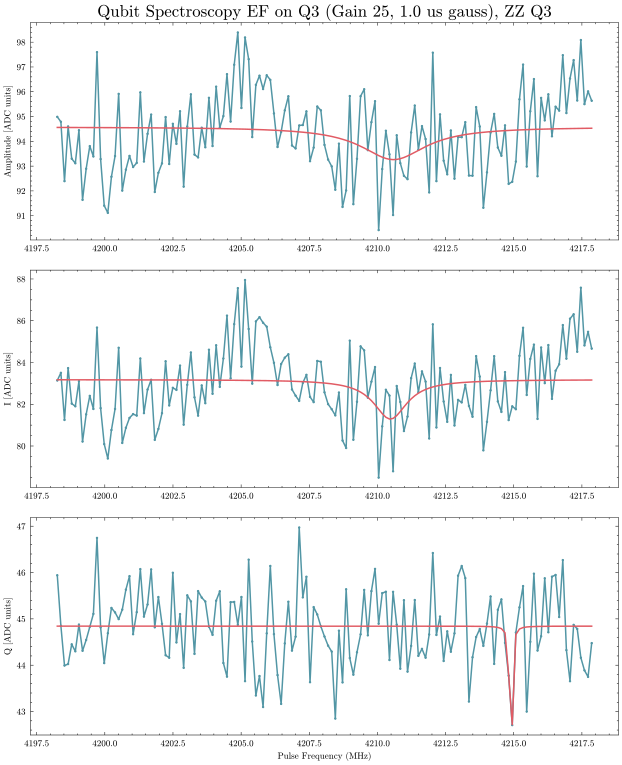

best 1 0.29018192553991284
Fit Q3 frequency with ZZ shift [MHz]: 4210.474626718808
Q3 shift due to Q3 in e [MHz]: 0.0


In [60]:
# for qTest in [3]:
    # for qZZ in [0]:
for qTest in [3]:
    for qZZ in [3]:
    # for qZZ in [0, 1]:

        # if not (qZZ == 0 and qTest == 1): continue
        # if 0 not in [qZZ, qTest]: continue
        # if 0 not in [qZZ, qTest] and 3 not in [qZZ, qTest]: continue

        # if qZZ == qTest: continue

        # if qZZ == 0 and qTest != 3: continue
        print('qTest', qTest, 'qZZ', qZZ)

        qZZspec = meas.PulseProbeSpectroscopyExperiment(
            soccfg=soc,
            path=expt_path,
            prefix=f"qubit_spectroscopy_qubit{qTest}{qZZ}",
            config_file=config_path,
        )
        
        span = 20
        npts = 151
        gain = int(np.reshape(yaml_cfg.device.qubit.pulses.pi_ef.gain, (4,4))[qTest, qTest]/60)
        # assert gain > 0
        
        qZZspec.cfg.expt = dict(
            start=np.reshape(yaml_cfg.device.qubit.f_ef, (4,4))[qTest, qTest]-span/2, # [MHz]
            step=span/npts,
            expts=npts, # Number of experiments stepping from start
            reps=100, # Number of averages per point
            rounds=8, # Number of start to finish sweeps to average over
            length=1.0, # qubit 0 probe constant pulse length [us]
            # gain=int(np.reshape(yaml_cfg.device.qubit.pulses.pi_ef.gain, (4,4))[qTest, qTest]/60), # Qubit pulse gain
            gain=gain, # Qubit pulse gain
            pulse_type='gauss',
            qTest=qTest,
            qZZ=qZZ,
            checkEF=True,
        )
        
        # qZZspec.cfg.device.readout.relax_delay = [10, 10, 10, 10] # Wait time between experiments [us]
        
        # print(qZZspec.cfg)
        
        qZZspec.go(analyze=False, display=False, progress=True, save=False)

        # ============ POST PROCESSING ============ #
        best_signs = [1, 0, 0]
        best_fit_err_i = np.inf
        best_fit_err_q = np.inf
        for sign in [1, -1]:
            try: 
                qZZspec.analyze(fit=True, signs=[1, sign, sign])
                fit_err_amps = qZZspec.data['fit_err_amps'][2][2]
                fit_err_i = qZZspec.data['fit_err_avgi'][2][2]
                fit_err_q = qZZspec.data['fit_err_avgq'][2][2]
                if fit_err_i < best_fit_err_i:
                    best_signs[1] = sign
                    best_fit_err_i = fit_err_i
                if fit_err_q < best_fit_err_q:
                    best_signs[2] = sign
                    best_fit_err_q = fit_err_q
            except: continue
        if fit_err_amps == np.inf and best_fit_err_i == np.inf and best_fit_err_q == np.inf:
            qZZspec.display(fit=False)
            print(f'WARNING: All fits failed for Q{qTest} due to Q{qZZ} in e, please manually fix!')
            continue

        qZZspec.analyze(fit=True, signs=best_signs)
        qZZspec.display(fit=True, signs=best_signs)

        qZZspec_fit, qZZspec_fit_err = meas.fitting.get_best_fit(qZZspec.data)

        yaml_cfg.device.qubit.f_ef = np.reshape(yaml_cfg.device.qubit.f_ef, (4,4))
        yaml_cfg.device.qubit.f_ef[qTest, qZZ] = qZZspec_fit[2]

        print(f'Fit Q{qTest} frequency with ZZ shift [MHz]: {qZZspec_fit[2]}')
        print(f'Q{qTest} shift due to Q{qZZ} in e [MHz]: {yaml_cfg.device.qubit.f_ef[qTest, qZZ] - yaml_cfg.device.qubit.f_ef[qTest, qTest]}')

        yaml_cfg.device.qubit.f_ef = yaml_cfg.device.qubit.f_ef.flatten().tolist()

Optional: update manual config now, or just keep running the T2R calibration cell using the already updated yaml_cfg variable

In [43]:
ZZshifts_ef = np.zeros((4,4))
reshaped_f_ef = np.reshape(yaml_cfg.device.qubit.f_ef, (4,4))
for row in range(4):
    for col in range(4):
        if row == col: continue
        if reshaped_f_ef[row, col] == 0:
            reshaped_f_ef[row, col] = reshaped_f_ef[row, row]

for row in range(4):
    ZZshifts_ef[row,:] = reshaped_f_ef[row,:] - reshaped_f_ef[row,row]
print('ZZ_efs:')
print(ZZshifts_ef)
# print(ZZshifts_ef.flatten().tolist())

print()
print(f'New f_ef\n', np.reshape(yaml_cfg.device.qubit.f_ef, (4,4)))

print()
print("UPDATE MANUALLY IN CONFIG:")
print(f'f_ef:')
print(yaml_cfg.device.qubit.f_ef)


ZZ_efs:
[[ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [-0.99906862 -1.89539749  0.          0.        ]
 [ 1.81489339 -3.02017066  0.          0.        ]]

New f_ef
 [[3884.96686009    0.            0.            0.        ]
 [   0.         3347.84622574    0.            0.        ]
 [4571.90564823 4571.00931937 4572.90471685    0.        ]
 [4211.70464568 4206.86958163    0.         4209.88975229]]

UPDATE MANUALLY IN CONFIG:
f_ef:
[3884.9668600899413, 0.0, 0.0, 0.0, 0.0, 3347.846225737386, 0.0, 0.0, 4571.9056482340775, 4571.009319367402, 4572.904716852475, 0.0, 4211.704645679207, 4206.869581627414, 0.0, 4209.889752285018]


## Fine EF with ZZ calibrations

In [54]:
save_data = False
saved_files = []

full_mux_expt = False
resonator_reset = [0, 2, 3] if full_mux_expt else None

In [56]:
import yaml
with open(config_path, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

In [57]:
test_pi_half = True
divide_len = True
# test_pi_half = True
# divide_len = False # for RB

do_length_rabi = do_amp_rabi = do_ramsey = do_amp_rabi_2 = do_error_amp = do_piminuspi = False

# SET THE EXPERIMENTS YOU WANT TO RUN HERE BY UNCOMMENTING!
# do_amp_rabi = True
do_ramsey = True
# do_piminuspi = True
# do_amp_rabi_2 = True
do_error_amp = True

sweep_phase = False
use_robust_pulses = True

# put an override=True flag to force skipping certain qubits

######### BEGINNING QUBIT 3 EF WITH ZZ FROM 3 #########
initial pi_len 0.03
initial pi_gain 1426
initial pi_freq 4208.123751627149
-------- Ramsey --------
Running Ramsey EF on Q3 


  0%|          | 0/10 [00:00<?, ?it/s]

best 0 0.14025868992269286
Current pi pulse frequency: 4208.123751627149
Fit frequency from amps [MHz]: 2.5559001490124023 +/- 0.052276082662950134
Suggested new pi pulse frequencies from fit amps [MHz]:
 	4208.067851478137
 	4203.067851478137
T2 Ramsey from fit amps [us]: 1.039341517857143 +/- 0.3694663748094943


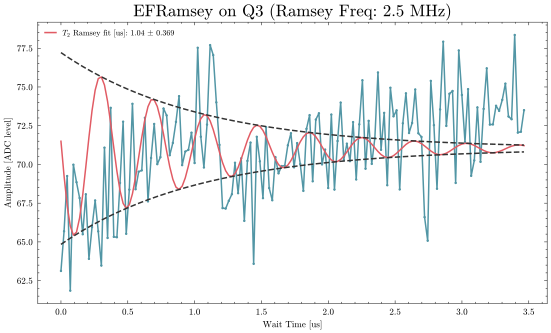

Current pi pulse frequency: 4208.123751627149
Fit frequency from I [MHz]: 2.690091596314513 +/- 0.052223490831280715
Suggested new pi pulse frequency from fit I [MHz]:
 	4207.933660030835
 	4202.933660030835
T2 Ramsey from fit I [us]: 1.039341517857143 +/- 0.34254392396664207
Fit frequency from Q [MHz]: 2.3830033575872513 +/- 0.04837140105006965
Suggested new pi pulse frequencies from fit Q [MHz]:
 	4208.240748269563
 	4203.240748269563
T2 Ramsey from fit Q [us]: 1.039341517857143 +/- 0.32619648923816413


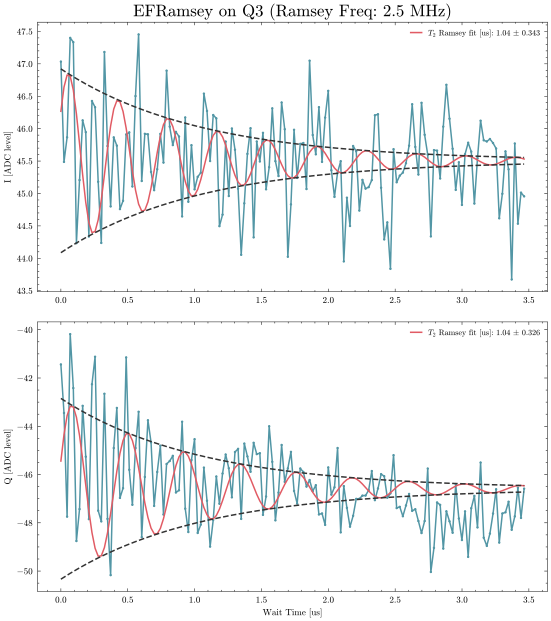

updated pi_freq 4208.067851478137
-------- Error amplification --------


  0%|          | 0/2 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [58]:
try: save_data
except: assert False, 'you did not run the cell above!'

thresholds=None
angles=None
ge_avgs=None
counts_calib=None

num_qubits_sample = 4

# for qTest in [0, 1]:
    # for qZZ in [0, 1]:
for qTest in [3]:
    # for qZZ in [0, 1, 2, 3]:
    for qZZ in [3]:

        if qTest == 0 or qTest == 1:
            if qZZ != qTest: continue

        if qTest == 2:
            if qZZ not in [1, 2]: continue
        if qTest == 3:
            if qZZ not in [0, 1, 3]: continue

        # if qTest == 2:
        #     if qZZ != 2: continue
        # if qTest == 3:
        #     if qZZ != 0: continue
        # if qZZ != qTest:
        #     if qTest not in [2, 3]: continue
        #     if qZZ not in [0, 2, 3]: continue
        #     if qTest == 2 and qZZ == 0: continue
        #     if qTest == 2 and qZZ == 3: continue
        #     # if qTest == 3 and qZZ == 2: continue
        # if qTest == 2 and qZZ == 2: continue

        # if qZZ != qTest: continue
        # if qZZ == 0 and qTest != 3: continue

        calib_index = qTest*num_qubits_sample + qZZ

        print(f"######### BEGINNING QUBIT {qTest} EF WITH ZZ FROM {qZZ} #########")

        # ----- Default values ----- #
        pi_len = np.reshape(yaml_cfg.device.qubit.pulses.pi_ef.sigma, (4,4))[qTest, qZZ]
        pi_gain = np.reshape(yaml_cfg.device.qubit.pulses.pi_ef.gain, (4,4))[qTest, qZZ]
        pi_freq = np.reshape(yaml_cfg.device.qubit.f_ef, (4,4))[qTest, qZZ]
        if test_pi_half:
            if divide_len:
                pi_gain = np.reshape(yaml_cfg.device.qubit.pulses.pi_ef.half_gain, (4,4))[qTest, qZZ]
            else:
                pi_gain = np.reshape(yaml_cfg.device.qubit.pulses.pi_ef.half_gain_pi_sigma, (4,4))[qTest, qZZ]
        print('initial pi_len', pi_len)
        print('initial pi_gain', pi_gain)
        print('initial pi_freq', pi_freq)
        override = False

        # For each experiment, update the relevant local variable pi_x, update the yaml and pass it to the next function


        # ----- Length Rabi ----- #
        if do_length_rabi and not override:
            pi_len = run_length_rabi(qZZ=qZZ, qTest=qTest, yaml_cfg=yaml_cfg, checkEF=True, test_pi_half=test_pi_half, divide_len=divide_len, save_data=save_data)
            # yaml_cfg.device.qubit.pulses.pi_ef.sigma[calib_index] = pi_len
            # print('updated pi_len', pi_len)
        override = False

        # ----- Amp Rabi ----- #
        # if qTest != 1: override = True
        if do_amp_rabi and not override:
            pi_gain = run_amp_rabi(qZZ=qZZ, qTest=qTest, yaml_cfg=yaml_cfg, checkEF=True, test_pi_half=test_pi_half, divide_len=divide_len, save_data=save_data)
            if test_pi_half:
                if divide_len: yaml_cfg.device.qubit.pulses.pi_ef.half_gain[calib_index] = pi_gain
                else: yaml_cfg.device.qubit.pulses.pi_ef.half_gain_pi_sigma[calib_index] = pi_gain
            else: yaml_cfg.device.qubit.pulses.pi_ef.gain[calib_index] = pi_gain
            print('updated pi_gain', pi_gain)
        override = False

        # ----- Ramsey ----- #
        # if 1 not in [qZZ, qTest]: override = True
        # if (qZZ == 1 and qTest == 0): override = True
        # if test_pi_half: override = True # ramsey not useful for pi half calibration
        if do_ramsey and not override:
            pi_freq = run_ramsey(qZZ=qZZ, qTest=qTest, yaml_cfg=yaml_cfg, checkEF=True, save_data=save_data)
            yaml_cfg.device.qubit.f_ef[calib_index] = pi_freq
            print('updated pi_freq', pi_freq)
        override = False

        # ----- Pi Minus Pi ----- #
        # if 1 not in [qZZ, qTest]: override = True
        # if (qZZ == 1 and qTest == 0): override = True
        if do_piminuspi and not override:
            pi_freq = run_piminuspi(qZZ=qZZ, qTest=qTest, test_pi_half=test_pi_half, checkEF=True, divide_len=divide_len, yaml_cfg=yaml_cfg, save_data=save_data)
            yaml_cfg.device.qubit.f_ef[calib_index] = pi_freq
            print('updated pi_freq', pi_freq)
        override = False

        # ----- Amp Rabi Round 2 ----- #
        # if qZZ == 0 and qTest == 1: override = True
        if do_amp_rabi_2 and not override:
            pi_gain = run_amp_rabi(qZZ=qZZ, qTest=qTest, yaml_cfg=yaml_cfg, checkEF=True, test_pi_half=test_pi_half, divide_len=divide_len, save_data=save_data)
            if test_pi_half:
                if divide_len: yaml_cfg.device.qubit.pulses.pi_ef.half_gain[calib_index] = pi_gain
                else: yaml_cfg.device.qubit.pulses.pi_ef.half_gain_pi_sigma[calib_index] = pi_gain
            else: yaml_cfg.device.qubit.pulses.pi_ef.gain[calib_index] = pi_gain
            print('updated pi_gain round 2', pi_gain)
        override = False

        # ----- Error amplification ----- #
        # if qZZ == 0 and qTest == 1: override = True
        if do_error_amp and not override:
            pi_gain = run_error_amp(qZZ=qZZ, qTest=qTest, yaml_cfg=yaml_cfg, checkEF=True, test_pi_half=test_pi_half, divide_len=divide_len, save_data=save_data)
            if test_pi_half:
                if divide_len: yaml_cfg.device.qubit.pulses.pi_ef.half_gain[calib_index] = pi_gain
                else: yaml_cfg.device.qubit.pulses.pi_ef.half_gain_pi_sigma[calib_index] = pi_gain
            else: yaml_cfg.device.qubit.pulses.pi_ef.gain[calib_index] = pi_gain
            print('updated pi_gain from error amplification', pi_gain)
        override = False

        print("\n\n")

In [30]:
print("UPDATE MANUALLY IN CONFIG:")
print('f_ef:')
print(yaml_cfg.device.qubit.f_ef)
print('pi_ef: sigma')
print(yaml_cfg.device.qubit.pulses.pi_ef.sigma)

if test_pi_half:
    if divide_len:
        print('pi_ef: half_gain')
        print(yaml_cfg.device.qubit.pulses.pi_ef.half_gain)
        print(np.reshape(yaml_cfg.device.qubit.pulses.pi_ef.half_gain, (4,4)))
    else:
        print('pi_ef: half_gain_pi_sigma')
        print(yaml_cfg.device.qubit.pulses.pi_ef.half_gain_pi_sigma)
        print(np.reshape(yaml_cfg.device.qubit.pulses.pi_ef.half_gain_pi_sigma, (4,4)))
else:
    print('pi_ef: gain')
    print(yaml_cfg.device.qubit.pulses.pi_ef.gain)
    print(np.reshape(yaml_cfg.device.qubit.pulses.pi_ef.gain, (4,4)))

print()
ZZshifts_ef = np.zeros((4,4))
reshaped_f_ef = np.reshape(yaml_cfg.device.qubit.f_ef, (4,4))
for row in range(4):
    for col in range(4):
        if row == col: continue
        if reshaped_f_ef[row, col] == 0:
            reshaped_f_ef[row, col] = reshaped_f_ef[row, row]

for row in range(4):
    ZZshifts_ef[row,:] = reshaped_f_ef[row,:] - reshaped_f_ef[row,row]
print('ZZ_efs:')
print(ZZshifts_ef)
# print(ZZshifts_ef.flatten().tolist())

print()
print(f'New f_ef\n', np.reshape(yaml_cfg.device.qubit.f_ef, (4,4)))

UPDATE MANUALLY IN CONFIG:
f_ef:
[3884.9668600899413, 0.0, 0.0, 0.0, 0.0, 3347.846225737386, 0.0, 0.0, 4571.9056482340775, 4571.009319367402, 4572.904716852475, 0.0, 4211.704645679207, 4206.869581627414, 0.0, 4209.889752285018]
pi_ef: sigma
[0.02, 0.02, 0.02, 0.02, 0.025, 0.025, 0.025, 0.025, 0.015, 0.015, 0.015, 0.015, 0.03, 0.03, 0.03, 0.03]
pi_ef: half_gain
[1243, 0, 0, 0, 0, 1945, 0, 0, 0, 6472, 6401, 0, 1427, 1601, 0, 1426]
[[1243    0    0    0]
 [   0 1945    0    0]
 [   0 6472 6401    0]
 [1427 1601    0 1426]]

ZZ_efs:
[[ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [-0.99906862 -1.89539749  0.          0.        ]
 [ 1.81489339 -3.02017066  0.          0.        ]]

New f_ef
 [[3884.96686009    0.            0.            0.        ]
 [   0.         3347.84622574    0.            0.        ]
 [4571.90564823 4571.00931937 4572.90471685    0.        ]
 [4211.70464568 4206.86958163    0.         4209.88975229]]


# Pi pulse train

https://arxiv.org/pdf/2304.06087

In [ ]:
checkEF = False

test_pi_half = True
divide_len = True
# test_pi_half = True
# divide_len = False # for RB

full_mux_expt = True
resonator_reset = [0, 2, 3]
use_robust_pulses = True

qTest = 0
qZZ = 0

In [83]:
train_expt = Experiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"pi_train_Q{qTest}{qZZ}",
    config_file=config_path,
)

npts_gain = 40
if checkEF:
    init_gain = train_expt.cfg.device.qubit.pulses.pi_ef.half_gain[qTest*4+qZZ]
else:
    init_gain = train_expt.cfg.device.qubit.pulses.pi_ge.half_gain[qTest*4+qZZ]
    if use_robust_pulses:
        init_gain = train_expt.cfg.device.qubit.pulses.pihalf_ge_robust.gain[qTest*4+qZZ]
span_gain = int(init_gain / 10)
start_gain = int(init_gain - span_gain/2)
gain_sweep = np.linspace(start_gain, start_gain + span_gain, npts_gain+1)
print(gain_sweep)

train_lens = [11, 31, 51]
# train_lens = [3, 5, 11, 21]

train_expt.cfg.expt = dict(
    train_lens=train_lens,
    gain_sweep=gain_sweep,

    reps=1000,
    loops=1,

    pulse_type='gauss',
    # post_process='threshold',
    post_process=None,
    # singleshot_reps=20000,

    test_pi_half=test_pi_half,
    divide_len=divide_len,
    error_amp=True,
    skip_first_pi2=True,

    checkEF=checkEF, 
    qTest=qTest,
    qZZ=qZZ,
    # readout_ge=not checkEF,
    readout_ge=True,

    full_mux_expt=full_mux_expt,
    resonator_reset=resonator_reset,

    use_robust_pulses=use_robust_pulses,
            
)

train_expt.data = dict(
    avgi = np.zeros((len(train_lens), len(gain_sweep))),
    avgq = np.zeros((len(train_lens), len(gain_sweep))),
    amps = np.zeros((len(train_lens), len(gain_sweep))),
)

thresholds = None
angles = None
ge_avgs = None
counts_calib = None

for i_npulses, npulses in enumerate(tqdm(train_lens)):
    for i_pulse_gain, pulse_gain in enumerate(tqdm(gain_sweep)):
        npulsecalib = meas.NPulseExperiment(
            soccfg=soc,
            path=expt_path,
            prefix=f"NPulseExptQ{qTest}{qZZ}",
            config_file=config_path,
        )

        npulsecalib.cfg.expt = dict(
            start=npulses, # number gate repetitions
            step=0,
            expts=1,
            # thresholds=thresholds,
            # angles=angles,
            # ge_avgs=ge_avgs,
            # counts_calib=counts_calib,
        )
        npulsecalib.cfg.expt.update(train_expt.cfg.expt)

        if checkEF:
            npulsecalib.cfg.device.qubit.pulses.pi_ef.half_gain[qTest*4+qZZ] = int(pulse_gain)
        else:
            npulsecalib.cfg.device.qubit.pulses.pi_ge.half_gain[qTest*4+qZZ] = int(pulse_gain)
            if use_robust_pulses:
                npulsecalib.cfg.device.qubit.pulses.pihalf_ge_robust.gain[qTest*4+qZZ] = int(pulse_gain)
            

        try:
            npulsecalib.acquire(progress=False, debug=False)
        except Exception:
            print("Pyro traceback:")
            print("".join(Pyro4.util.getPyroTraceback()))
        
        for data_name in ['avgi', 'avgq', 'amps']:
            train_expt.data[data_name][i_npulses, i_pulse_gain] = npulsecalib.data[data_name]
        
        # thresholds = npulsecalib.data['thresholds']
        # angles = npulsecalib.data['angles']
        # ge_avgs = npulsecalib.data['ge_avgs']
        # counts_calib = npulsecalib.data['counts_calib']

[7095.   7113.65 7132.3  7150.95 7169.6  7188.25 7206.9  7225.55 7244.2
 7262.85 7281.5  7300.15 7318.8  7337.45 7356.1  7374.75 7393.4  7412.05
 7430.7  7449.35 7468.   7486.65 7505.3  7523.95 7542.6  7561.25 7579.9
 7598.55 7617.2  7635.85 7654.5  7673.15 7691.8  7710.45 7729.1  7747.75
 7766.4  7785.05 7803.7  7822.35 7841.  ]


100%|██████████| 3/3 [01:44<00:00, 34.88s/it]


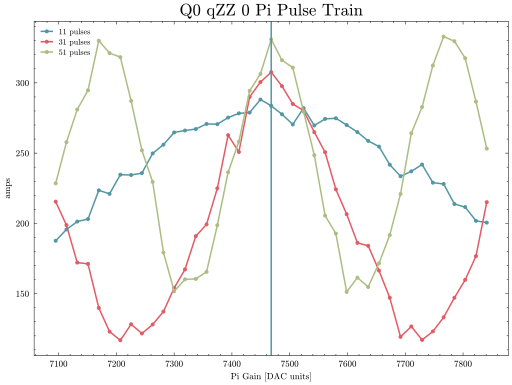

In [85]:
data_name = "amps"

plt.figure(figsize=(8, 6))
for i_npulses, npulses in enumerate(train_lens):
    plt.plot(gain_sweep, train_expt.data[data_name][i_npulses, :], 'o-', label=f'{npulses} pulses')
plt.xlabel("Pi Gain [DAC units]")
plt.ylabel(data_name)
plt.legend()
plt.title(f"Q{train_expt.cfg.expt.qTest} qZZ {train_expt.cfg.expt.qZZ} {'EF' if checkEF else ''}Pi Pulse Train")
plt.axvline(7468)
plt.show()


In [ ]:
print(train_expt.save_data())

S:\QRAM\qram_4QR2\data\data_241025\00001_eggf_train_Q31.h5


# Get couplings and bare qubit and ef frequencies by optimization

In [29]:
sys.path.append(os.getcwd()+'/../../qutip_sims')
from QSwitch import QSwitch, get_bare_params_from_coupled, gs_mat_from_gs_arr

In [30]:
import yaml
with open(config_path, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

In [31]:
qubit_ZZ_freqs_MHz = np.array(np.reshape(yaml_cfg.device.qubit.f_ge, (4,4)))
ef_ZZ_freqs_MHz = np.array(np.reshape(yaml_cfg.device.qubit.f_ef, (4,4)))

qubit_freqs_MHz = qubit_ZZ_freqs_MHz.diagonal()
ef_freqs_MHz = ef_ZZ_freqs_MHz.diagonal()
ZZshifts_MHz = np.zeros((4,4))
for row in range(4):
    ZZshifts_MHz[row,:] = qubit_ZZ_freqs_MHz[row,:] - qubit_ZZ_freqs_MHz[row,row]

In [32]:
fges_opt_MHz, alphas_opt_MHz, gs_opt_MHz, error = get_bare_params_from_coupled(qubit_ZZ_freqs_MHz, ef_ZZ_freqs_MHz)

qubit_freqs [4111.14452003 3448.3482722  4762.90042147 4381.20059833]
ef_freqs [3885.31178849 3347.84808885 4572.97170227 4209.90055906]
alphas [-225.83273154 -100.50018335 -189.9287192  -171.30003927]
x0 [4111.14452003 3448.3482722  4762.90042147 4381.20059833 -225.83273154
 -100.50018335 -189.9287192  -171.30003927   50.           50.
   50.            5.            5.            5.        ]
Success: True


In [33]:
qram = QSwitch(
    EJs=None,
    ECs=None,
    gs=1e-3*gs_mat_from_gs_arr(gs_opt_MHz),
    qubit_freqs=1e-3*fges_opt_MHz,
    alphas=1e-3*alphas_opt_MHz,
    cutoffs=[4, 5, 4, 4],
    isCavity=[False]*4,
)
print('Measured (coupled) qubits freqs [MHz]')
print(qubit_freqs_MHz)
print('Measured (coupled) ef freqs [MHz]')
print(ef_freqs_MHz)
print()

print('Optimized (uncoupled) qubit freqs [MHz]')
print(fges_opt_MHz)
print('Optimized (uncoupled) alphas [MHz]')
print(alphas_opt_MHz)

optimized_fges = []
optimized_fefs = []
gstate = 'gggg'
for i in range(4):
    estate = gstate[:i] + 'e' + gstate[i+1:]
    optimized_fges.append(1e3*(qram.get_base_wd(gstate, estate)/2/np.pi))
    fstate = gstate[:i] + 'f' + gstate[i+1:]
    optimized_fefs.append(1e3*(qram.get_base_wd(estate, fstate)/2/np.pi))
print('Optimized (coupled) qubit freqs [MHz]')
print(optimized_fges)
print('Optimized (coupled) qubit ef freqs [MHz]')
print(optimized_fefs)
print(f'Optimized g01, g12, g13, g02, g03, g23 [MHz]')
print('gs: [', end='')
print(*(gs_opt_MHz), sep=', ', end=']\n')
print()
print('ZZ matrix = (QA freq when QB is in e) - (QA freq when QB is in g) [MHz]')
print('Down: spectroscopy qubit (QA), Right: pi pulse qubit (QB)')
print('Measured ZZ matrix [MHz]')
print(ZZshifts_MHz)
print('Optimized ZZ matrix [MHz]')
print(1e3*qram.get_ZZ_matrix())
print()
print(f'Optimization error: {error}')

Measured (coupled) qubits freqs [MHz]
[4111.14452003 3448.3482722  4762.90042147 4381.20059833]
Measured (coupled) ef freqs [MHz]
[3885.31178849 3347.84808885 4572.97170227 4209.90055906]

Optimized (uncoupled) qubit freqs [MHz]
[4107.1879837  3456.83926434 4760.33253861 4379.23469519]
Optimized (uncoupled) alphas [MHz]
[-230.2671412  -102.31221745 -191.20976059 -172.77789747]
Optimized (coupled) qubit freqs [MHz]
[4111.144804116175, 3448.348713188007, 4762.900474336899, 4381.200490193879]
Optimized (coupled) qubit ef freqs [MHz]
[3885.311377916923, 3347.847820505474, 4572.97146161569, 4209.900645468311]
Optimized g01, g12, g13, g02, g03, g23 [MHz]
gs: [52.51531718858716, 55.05491029594427, 43.88786305808141, 4.623124293458531, 2.6196540253919784, 6.2976632340250775]

ZZ matrix = (QA freq when QB is in e) - (QA freq when QB is in g) [MHz]
Down: spectroscopy qubit (QA), Right: pi pulse qubit (QB)
Measured ZZ matrix [MHz]
[[ 0.         -5.36056122 -0.14162359 -0.54782372]
 [-5.36871697  